In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
pjme = pd.read_csv('/Users/sean/Downloads/energy_forecast/PJME_hourly.csv',
                  index_col=[0], parse_dates=[0])

In [3]:
plt.style.use('fivethirtyeight')

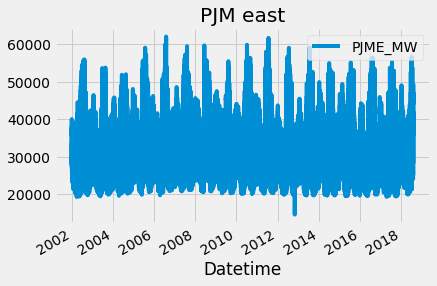

In [4]:
pjme.plot(title='PJM east')

In [5]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [7]:
def extract_window(dataframe): 
    cols = []
    for i in range(10, -1, -1): 
        cols.append(dataframe.shift(i))
        
    df= pd.concat(cols, axis=1)
    df.columns = ['t-%d' %k for k in range(10, -1, -1)]
    df = df.dropna()
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    return x, y

In [8]:
pjme_x, pjme_y = extract_window(pjme)

In [9]:
def extract_feats(df): 
    df['date'] = df.index.day
    df['month']  = df.index.month
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    df['day_of_week'] = df.index.dayofweek
    df['week_of_year'] = df.index.weekofyear
    return df

In [10]:
pjme_x = extract_feats(pjme_x)
pjme_x.head()

/anaconda3/envs/ee127/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,date,month,hour,day_of_year,day_of_week,week_of_year
Datetime,,,,,,,,,,,,,,,,
2002-12-31 11:00:00,26498.0,25147.0,24574.0,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,31,12,11,365,1,1
2002-12-31 12:00:00,25147.0,24574.0,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31,12,12,365,1,1
2002-12-31 13:00:00,24574.0,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31902.0,31,12,13,365,1,1
2002-12-31 14:00:00,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31902.0,31126.0,31,12,14,365,1,1
2002-12-31 15:00:00,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31902.0,31126.0,30368.0,31,12,15,365,1,1


In [11]:
split_date = '01-01-2015'

x_tr = pjme_x.loc[pjme_x.index < split_date]
y_tr = pjme_y.loc[pjme_y.index < split_date]

x_te = pjme_x.loc[pjme_x.index >= split_date]
y_te = pjme_y.loc[pjme_y.index >= split_date]

In [12]:
from xgboost import XGBRegressor

In [13]:
model = XGBRegressor()

In [14]:
# Make the dataset
x_te = x_te[10:]
y_te = y_te[10:]

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                      min_child_weight=10)

print(len(x_tr), len(y_tr))

113916 113916


In [16]:
reg.fit(x_tr, y_tr, 
       eval_set=[(x_tr, y_tr), (x_te, y_te)],
       early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:23070.53711	validation_1-rmse:22374.84570
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:16171.92578	validation_1-rmse:15657.59082
[2]	validation_0-rmse:11345.13672	validation_1-rmse:10958.80859
[3]	validation_0-rmse:7970.34619	validation_1-rmse:7682.02100
[4]	validation_0-rmse:5614.68555	validation_1-rmse:5399.22412
[5]	validation_0-rmse:3974.51367	validation_1-rmse:3812.04907
[6]	validation_0-rmse:2840.79614	validation_1-rmse:2719.45508
[7]	validation_0-rmse:2065.29028	validation_1-rmse:1977.26221
[8]	validation_0-rmse:1544.33276	validation_1-rmse:1489.51843
[9]	validation_0-rmse:1204.39539	validation_1-rmse:1178.74255
[10]	validation_0-rmse:988.65430	validation_1-rmse:993.11713
[11]	validation_0-rmse:860.40478	validation_1-rmse:887.07202
[12]	validation_0-rmse:785.37109	validation_1-rmse:828.23969
[13]	validation_0-rmse:742.66705

[131]	validation_0-rmse:463.84198	validation_1-rmse:670.65759
[132]	validation_0-rmse:463.26355	validation_1-rmse:670.19910
[133]	validation_0-rmse:462.71371	validation_1-rmse:670.10443
[134]	validation_0-rmse:462.26373	validation_1-rmse:669.75555
[135]	validation_0-rmse:461.59293	validation_1-rmse:669.46271
[136]	validation_0-rmse:461.52130	validation_1-rmse:669.45398
[137]	validation_0-rmse:460.69360	validation_1-rmse:669.22345
[138]	validation_0-rmse:460.62091	validation_1-rmse:669.21698
[139]	validation_0-rmse:459.65048	validation_1-rmse:668.84735
[140]	validation_0-rmse:459.42349	validation_1-rmse:668.75500
[141]	validation_0-rmse:458.67056	validation_1-rmse:668.72321
[142]	validation_0-rmse:457.78699	validation_1-rmse:668.90241
[143]	validation_0-rmse:457.47553	validation_1-rmse:668.71417
[144]	validation_0-rmse:457.34204	validation_1-rmse:668.66827
[145]	validation_0-rmse:456.48358	validation_1-rmse:668.57385
[146]	validation_0-rmse:455.35712	validation_1-rmse:668.75446
[147]	va

[264]	validation_0-rmse:394.06607	validation_1-rmse:664.46802
[265]	validation_0-rmse:393.84348	validation_1-rmse:664.32251
[266]	validation_0-rmse:393.44076	validation_1-rmse:664.50848
[267]	validation_0-rmse:393.18808	validation_1-rmse:664.26294
[268]	validation_0-rmse:392.65082	validation_1-rmse:664.17188
[269]	validation_0-rmse:392.07089	validation_1-rmse:664.28052
[270]	validation_0-rmse:391.63705	validation_1-rmse:664.43286
[271]	validation_0-rmse:391.25360	validation_1-rmse:664.39032
[272]	validation_0-rmse:391.04453	validation_1-rmse:664.29291
[273]	validation_0-rmse:390.99957	validation_1-rmse:664.27325
[274]	validation_0-rmse:390.25723	validation_1-rmse:664.28088
[275]	validation_0-rmse:389.95129	validation_1-rmse:664.24286
[276]	validation_0-rmse:389.80768	validation_1-rmse:664.14032
[277]	validation_0-rmse:389.64331	validation_1-rmse:664.10809
[278]	validation_0-rmse:389.04871	validation_1-rmse:664.20740
[279]	validation_0-rmse:388.06277	validation_1-rmse:664.19727
[280]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

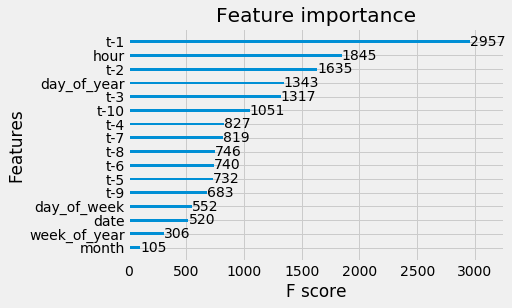

In [17]:
from xgboost import plot_tree

xgb.plot_importance(reg)

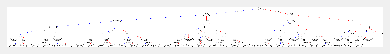

In [21]:

xgb.plot_tree(reg, num_trees=0)

In [22]:
x_te.shape, y_te.shape

np.linalg.norm(np.expand_dims(reg.predict(x_te), axis=-1) - y_te, ord=1)/len(x_te)

339.71697130776727

In [23]:
import ray
from ray import tune

In [24]:
# ray.services.get_node_ip_address = lambda: '127.0.0.1'
ray.init(local_mode=True,num_cpus=1, num_gpus=0)

2020-12-09 18:11:29,487	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.4.26',
 'raylet_ip_address': '192.168.4.26',
 'redis_address': '192.168.4.26:6379',
 'object_store_address': '/tmp/ray/session_2020-12-09_18-11-28_948067_90177/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-09_18-11-28_948067_90177/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-12-09_18-11-28_948067_90177',
 'metrics_export_port': 62773,
 'node_id': '73c18b79c238ce893a49ad944319e3781b69c309'}

In [111]:
def training_function(config): 
    reg = xgb.XGBRegressor(n_estimators=100, **config)
    reg.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_te, y_te)], 
           early_stopping_rounds=10, verbose=True)

    mae = np.linalg.norm(np.expand_dims(reg.predict(x_te), axis=-1) - y_te, ord=1)/len(x_te)
    tune.report(mean_loss=mae, done=True)
    
config = {
    'max_depth':tune.randint(1, 9), 
    'min_child_weight':tune.choice([1,2,3]),
    'eta':tune.loguniform(1e-4, 1e-1)
}  
    
analysis = tune.run(
    training_function,
    resources_per_trial={
        'cpu':1
    },
    config=config,
    num_samples=10
)

[0]	validation_0-rmse:32794.40625	validation_1-rmse:31851.27344
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:32661.73828	validation_1-rmse:31721.99219
[2]	validation_0-rmse:32529.63086	validation_1-rmse:31593.24219
[3]	validation_0-rmse:32398.06836	validation_1-rmse:31465.03125
[4]	validation_0-rmse:32267.02539	validation_1-rmse:31337.32617
[5]	validation_0-rmse:32136.51367	validation_1-rmse:31210.16992
[6]	validation_0-rmse:32006.55469	validation_1-rmse:31083.51562
[7]	validation_0-rmse:31877.10156	validation_1-rmse:30957.39453
[8]	validation_0-rmse:31748.18555	validation_1-rmse:30831.76562
[9]	validation_0-rmse:31619.78906	validation_1-rmse:30706.66406
[10]	validation_0-rmse:31491.89648	validation_1-rmse:30582.07812
[11]	validation_0-rmse:31364.55859	validation_1-rmse:30458.00781
[12]	validation_0-rmse:31237.73633	validation_1-rmse:30334.45898
[13]	v

2020-12-09 13:46:47,104	WARNING util.py:140 -- The `start_trial` operation took 3.3906729221343994 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,eta,max_depth,min_child_weight
training_function_07286_00000,RUNNING,,0.00405931,3,3


Result for training_function_07286_00000:
  date: 2020-12-09_13-46-47
  done: true
  experiment_id: 8886c06828d14a9283a66364ea0f2dfc
  experiment_tag: 0_eta=0.0040593,max_depth=3,min_child_weight=3
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 1
  mean_loss: 20820.033598861184
  neg_mean_loss: -20820.033598861184
  node_ip: 192.168.4.26
  pid: 70293
  time_since_restore: 3.000480890274048
  time_this_iter_s: 3.000480890274048
  time_total_s: 3.000480890274048
  timestamp: 1607550407
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 07286_00000
  
[0]	validation_0-rmse:32865.69531	validation_1-rmse:31920.80469
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:32803.93359	validation_1-rmse:31860.62695
[2]	validation_0-rmse:32742.27344	validation_1-rmse:31800.56055
[3]	validation_0-rmse:32680.74023	validation_1-rmse:31740.6230

2020-12-09 13:46:53,725	WARNING util.py:140 -- The `start_trial` operation took 6.449634075164795 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,eta,max_depth,min_child_weight,loss,iter,total time (s),neg_mean_loss
training_function_07286_00001,RUNNING,,0.00188274,8,1,,,,
training_function_07286_00000,TERMINATED,,0.00405931,3,3,20820,1,3.00048,-20820


2020-12-09 13:46:53,873	ERROR trial_runner.py:793 -- Trial training_function_07286_00001: Error processing event.
Traceback (most recent call last):
  File "/anaconda3/envs/ee127/lib/python3.6/site-packages/ray/tune/trial_runner.py", line 726, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/anaconda3/envs/ee127/lib/python3.6/site-packages/ray/tune/ray_trial_executor.py", line 489, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/anaconda3/envs/ee127/lib/python3.6/site-packages/ray/worker.py", line 1452, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError: ray::ImplicitFunc.train() (pid=70293, ip=192.168.4.26)
  File "python/ray/_raylet.pyx", line 436, in ray._raylet.execute_task.function_executor
  File "/anaconda3/envs/ee127/lib/python3.6/site-packages/ray/tune/trainable.py", line 336, in train
    result = self.step()
  File "/anaconda3/envs/ee127/lib/python3.6/site-packages/ray/tune/funct

[0]	validation_0-rmse:32915.66016	validation_1-rmse:31969.48047
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:32903.74609	validation_1-rmse:31957.86523
[2]	validation_0-rmse:32891.84375	validation_1-rmse:31946.26367
[3]	validation_0-rmse:32879.91406	validation_1-rmse:31934.65039
[4]	validation_0-rmse:32868.00781	validation_1-rmse:31923.04688
[5]	validation_0-rmse:32856.10938	validation_1-rmse:31911.44922
[6]	validation_0-rmse:32844.21484	validation_1-rmse:31899.85742
[7]	validation_0-rmse:32832.32031	validation_1-rmse:31888.27734
[8]	validation_0-rmse:32820.42969	validation_1-rmse:31876.69727
[9]	validation_0-rmse:32808.55078	validation_1-rmse:31865.11914
[10]	validation_0-rmse:32796.64062	validation_1-rmse:31853.54688
[11]	validation_0-rmse:32784.79297	validation_1-rmse:31841.97070
[12]	validation_0-rmse:32772.92578	validation_1-rmse:31830.40234
[13]	v

2020-12-09 13:47:00,683	WARNING util.py:140 -- The `start_trial` operation took 6.80215311050415 seconds to complete, which may be a performance bottleneck.


Result for training_function_07286_00002:
  date: 2020-12-09_13-47-00
  done: true
  experiment_id: 7620ae9d1f0b4422a8dc87a3f25e44a8
  experiment_tag: 2_eta=0.00036277,max_depth=8,min_child_weight=2
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 1
  mean_loss: 30205.266973506044
  neg_mean_loss: -30205.266973506044
  node_ip: 192.168.4.26
  pid: 70293
  time_since_restore: 6.562814950942993
  time_this_iter_s: 6.562814950942993
  time_total_s: 6.562814950942993
  timestamp: 1607550420
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 07286_00002
  
[0]	validation_0-rmse:32478.83594	validation_1-rmse:31543.43164
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:32036.21484	validation_1-rmse:31111.79297
[2]	validation_0-rmse:31599.64453	validation_1-rmse:30685.99805
[3]	validation_0-rmse:31169.06445	validation_1-rmse:30266.251

2020-12-09 13:47:04,940	WARNING util.py:140 -- The `start_trial` operation took 4.095945119857788 seconds to complete, which may be a performance bottleneck.


Result for training_function_07286_00003:
  date: 2020-12-09_13-47-04
  done: true
  experiment_id: 6a85a487bd67489e9fb23586221f465a
  experiment_tag: 3_eta=0.013664,max_depth=4,min_child_weight=3
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 1
  mean_loss: 7823.730119449471
  neg_mean_loss: -7823.730119449471
  node_ip: 192.168.4.26
  pid: 70293
  time_since_restore: 3.8458189964294434
  time_this_iter_s: 3.8458189964294434
  time_total_s: 3.8458189964294434
  timestamp: 1607550424
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 07286_00003
  
[0]	validation_0-rmse:32915.48828	validation_1-rmse:31969.29297
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:32903.37500	validation_1-rmse:31957.50391
[2]	validation_0-rmse:32891.28125	validation_1-rmse:31945.70703
[3]	validation_0-rmse:32879.19141	validation_1-rmse:31933.9218

2020-12-09 13:47:08,592	WARNING util.py:140 -- The `start_trial` operation took 3.502769708633423 seconds to complete, which may be a performance bottleneck.


Result for training_function_07286_00004:


KeyboardInterrupt: 

In [25]:
# More advanced Ray tuning
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.tune.schedulers import ASHAScheduler

def train_xgb_asha(config): 
    train_set = xgb.DMatrix(x_tr, label=y_tr)
    test_set = xgb.DMatrix(x_te, label=y_te)
    
    xgb.train(
        config,
        train_set, 
        100,
        evals=[(test_set, 'eval')], 
        verbose_eval=False, 
        early_stopping_rounds=10,
        callbacks=[TuneReportCheckpointCallback(filename='model.xgb')])
    
config={ 
    'objective':'reg:squarederror', 
    "eval_metric":['mae'],
    'max_depth':tune.randint(1,9),
    'min_child_weight':tune.choice([1, 2, 3]), 
    'subsample':tune.uniform(0.5, 1.0), 
    'eta':tune.uniform(1e-4, 1e-1),
}
    
scheduler=ASHAScheduler(
    time_attr='training_iteration',
    max_t=1000, 
    grace_period=1, 
    reduction_factor=2
)
    
analysis = tune.run(
    train_xgb_asha, 
    metric='eval-mae', 
    mode='min', 
    resources_per_trial={'cpu':1}, 
    config=config, 
    num_samples=10, 
    scheduler=scheduler
)


2020-12-09 18:11:40,928	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2020-12-09 18:11:41,330	INFO logger.py:201 -- pip install 'ray[tune]' to see TensorBoard files.
2020-12-09 18:11:41,332	WARNING logger.py:343 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.


Trial name,status,loc,eta,max_depth,min_child_weight,subsample
train_xgb_asha_0ace0_00000,RUNNING,,0.00740211,5,1,0.98151


Result for train_xgb_asha_0ace0_00000:
  date: 2020-12-09_18-11-41
  done: false
  eval-mae: 31091.0
  experiment_id: a3f186a344fa477ca1a5b4c822557da2
  experiment_tag: 0_eta=0.0074021,max_depth=5,min_child_weight=1,subsample=0.98151
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 1
  node_ip: 192.168.4.26
  pid: 90177
  should_checkpoint: true
  time_since_restore: 0.20360183715820312
  time_this_iter_s: 0.20360183715820312
  time_total_s: 0.20360183715820312
  timestamp: 1607566301
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0ace0_00000
  


KeyboardInterrupt: 

In [ ]:
pjme_test.head()

# pjme_test['MW_Prediction'] = reg.predict(x_te)

pjme_test = pjme_test[3:]

pjme_test['predictions']= reg.predict(x_te)



f, ax = plt.subplots(1)
pjme_test.plot(figsize=(15,5), ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')


f, ax = plt.subplots(1)
pjme_test.plot(figsize=(15,5), ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')

mean_squared_error(y_true = pjme_test['PJME_MW'], 
                  y_pred=pjme_test['predictions'])

mean_absolute_error(y_true = pjme_test['PJME_MW'],
                   y_pred = pjme_test['predictions'])

def mape(pred, true): 
    pred = np.array(pred)
    true = np.array(true)
    return np.abs((pred-true)/true).mean()*100

mape(pjme_test['PJME_MW'], pjme_test['predictions'])

pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['predictions']
pjme_test['error'] = pjme_test['error'].apply(np.abs)

pjme_test.head()

x_te['pred'] = reg.predict(x_te)
x_te['real'] = y_te

In [ ]:
error_by_day = x_te.copy()

error_by_day['error'] = error_by_day['pred'] - error_by_day['real']
error_by_day['error'] = error_by_day['error'].apply(np.abs)

In [ ]:
error_by_day = error_by_day.groupby(['dayofmonth', 'month', 'year']).mean()

In [ ]:
error_by_day.sort_values('error', ascending=True).head(10)

In [ ]:
x_tr

In [ ]:
import tensorflow as tf

In [ ]:
X_tr = x_tr.values
Y = y_tr.values

X_te = x_te.values
Y_te = y_te.values

# mu = np.mean(X_tr[:-3])
# std = np.std(X_tr[:-3])
# X_tr[:-3] -= mu
# X_tr[:-3] /= std

# X_te[:-3] -= mu
# X_te[:-3] /= std

In [ ]:
import tensorflow.keras as keras


In [ ]:
def undump_Y(Y):
    Y = [y for y in Y]
    Y = np.array(Y)
    return Y


In [ ]:
Y = undump_Y(Y)
Y_te = undump_Y(Y_te)
print(Y_te.shape, X_te.shape)
X_te = X_te[:, :X_te.shape[-1]]

In [ ]:
X_tr= X_tr.astype(float)
X_te = X_te.astype(float)

mu, s = np.mean(Y), np.std(Y)

Y = Y - mu
Y /= s
Y_te = Y_te-mu
Y_te /= s

In [ ]:
Y_te = np.squeeze(Y_te)
Y = np.squeeze(Y)
Y_tr = Y

In [ ]:
tf.keras.backend.clear_session()
x= tf.keras.layers.Input(shape=11)
y = tf.keras.layers.Dense(20)(x)
y = tf.keras.layers.Dense(20)(y)
y = tf.keras.layers.Dropout(0.9)(y)
y = tf.keras.layers.Dense(1)(y)
model = tf.keras.Model(x, y)

In [ ]:
model.compile(optimizer='adam', 
             loss='mean_squared_error', 
             metrics=['mae'])


In [ ]:
model.fit(X_tr, Y_tr, validation_data=(X_te[:256], Y_te[:256]),
         epochs=100, batch_size=32)